In [1]:
!pip install opencv-python

In [2]:
import os
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Lab Task 1: Geometric Rectification of Satellite Imagery

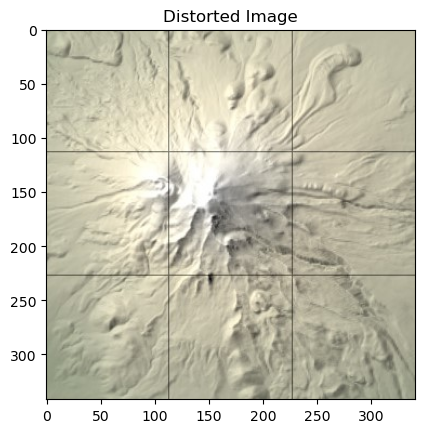

In [3]:
# Load the distorted image
distorted_image = cv2.imread('sat_distort.jpg')
image_dis = cv2.cvtColor(distorted_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_dis)
plt.title('Distorted Image')
plt.show()

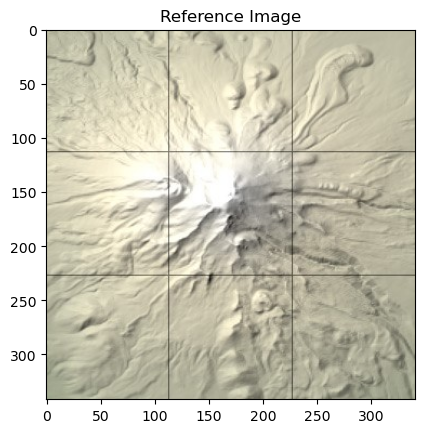

In [4]:
# Load the reference image
reference_image = cv2.imread('sat_reference.jpg')
image_ref = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_ref)
plt.title('Reference Image')
plt.show()

In [5]:
# Function to detect GCPs using ORB and match between distorted and reference images
def find_gcp(distorted_image_path, reference_image_path):
    try:
        # Load the distorted and reference images in grayscale
        distorted_image = cv2.imread(distorted_image_path, 0)
        reference_image = cv2.imread(reference_image_path, 0)
        
        if distorted_image is None or reference_image is None:
            raise FileNotFoundError("Error: One or both of the image paths provided are incorrect or the files do not exist.")
        
        # Initialize ORB detector
        orb = cv2.ORB_create()

        # Detect keypoints and descriptors
        keypoints_1, descriptors_1 = orb.detectAndCompute(distorted_image, None)
        keypoints_2, descriptors_2 = orb.detectAndCompute(reference_image, None)

        if len(keypoints_1) == 0 or len(keypoints_2) == 0:
            raise ValueError("Error: ORB could not detect any keypoints in one or both of the images.")

        # Use BFMatcher (Brute Force Matcher) to find the best matches
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors_1, descriptors_2)

        if len(matches) == 0:
            raise ValueError("Error: No good matches were found between the distorted and reference images.")

        # Sort matches based on distance (lower distance is better)
        matches = sorted(matches, key=lambda x: x.distance)

        # Draw the top 10 matches for visualization
        matched_image = cv2.drawMatches(distorted_image, keypoints_1, reference_image, keypoints_2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Convert the BGR image to RGB for plt (Matplotlib expects RGB format)
        matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

        # Display the matched image using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(matched_image_rgb)
        plt.title("Matched Ground Control Points (GCPs)")
        plt.axis('off')  # Hide axes for a cleaner look
        plt.show()

        # Extract the matching keypoints as GCPs
        gcp_list_distorted = np.float32([keypoints_1[m.queryIdx].pt for m in matches[:10]])
        gcp_list_reference = np.float32([keypoints_2[m.trainIdx].pt for m in matches[:10]])

        return gcp_list_distorted, gcp_list_reference

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except ValueError as val_error:
        print(val_error)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

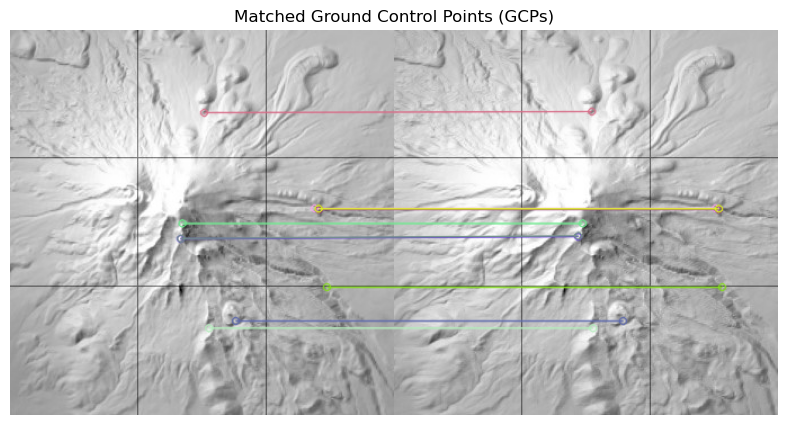

Ground Control Points (Distorted Image): [[270.      158.     ]
 [200.      258.     ]
 [274.      159.     ]
 [151.      185.     ]
 [152.64    171.36   ]
 [172.       73.     ]
 [273.6     158.40001]
 [151.20001 184.8    ]
 [176.25601 264.38403]
 [281.      228.     ]]
Ground Control Points (Reference Image): [[285.      158.     ]
 [203.      258.     ]
 [288.      159.     ]
 [163.      183.     ]
 [167.04001 171.36   ]
 [175.20001  72.     ]
 [288.      158.40001]
 [163.20001 182.40001]
 [176.25601 264.38403]
 [291.      228.     ]]


In [6]:
# Paths to the distorted and reference images
distorted_image_path = 'sat_distort.jpg'
reference_image_path = 'sat_reference.jpg'

# Call the function to find GCPs
gcp_distorted, gcp_reference = find_gcp(distorted_image_path, reference_image_path)

# Print the GCPs for further use
if gcp_distorted is not None and gcp_reference is not None:
    print("Ground Control Points (Distorted Image):", gcp_distorted)
    print("Ground Control Points (Reference Image):", gcp_reference)

In [7]:
# Distorted image GCPs (provided)
# distorted_points = np.float32([
#     [270.0, 158.0],
#     [200.0, 258.0],
#     [274.0, 159.0],
#     [151.0, 185.0],
#     [152.64, 171.36],
#     [172.0, 73.0],
#     [273.6, 158.40001],
#     [151.20001, 184.8],
#     [176.25601, 264.38403],
#     [281.0, 228.0]
# ])

# # Reference image GCPs (provided)
# rectified_points = np.float32([
#     [285.0, 158.0],
#     [203.0, 258.0],
#     [288.0, 159.0],
#     [163.0, 183.0],
#     [167.04001, 171.36],
#     [175.20001, 72.0],
#     [288.0, 158.40001],
#     [163.20001, 182.40001],
#     [176.25601, 264.38403],
#     [291.0, 228.0]
# ])

In [8]:
#Use the first 4 GCPs to calculate the perspective transformation matrix
# Distorted image GCPs (provided) - Use the first 4 points
distorted_points = np.float32([
    [270.0, 158.0],
    [200.0, 258.0],
    [274.0, 159.0],
    [151.0, 185.0]
])

# Reference image GCPs (provided) - Use the first 4 points
rectified_points = np.float32([
    [285.0, 158.0],
    [203.0, 258.0],
    [288.0, 159.0],
    [163.0, 183.0]
])

In [9]:
# Get the transformation matrix
matrix = cv2.getPerspectiveTransform(distorted_points, rectified_points)

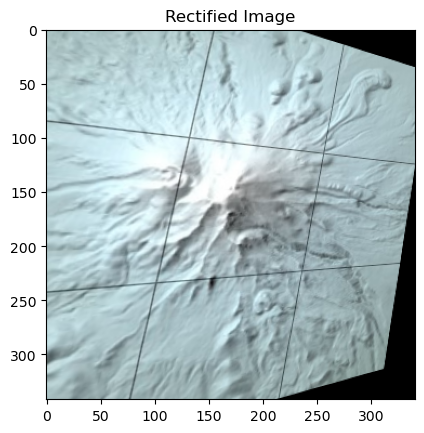

In [10]:
# Apply the perspective transformation
rectified_image = cv2.warpPerspective(image_dis, matrix, (image_dis.shape[1], image_dis.shape[0]), flags=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(rectified_image, cv2.COLOR_BGR2RGB))
plt.title('Rectified Image')
plt.show()

In [12]:
# Compute MSE between the original and rectified images
mse_value = mean_squared_error(image_dis.flatten(), rectified_image.flatten())
print(f'Mean Squared Error: {mse_value}')

Mean Squared Error: 89.32707379396683


## Report:

# Lab Task 2: Medical Image Rectification

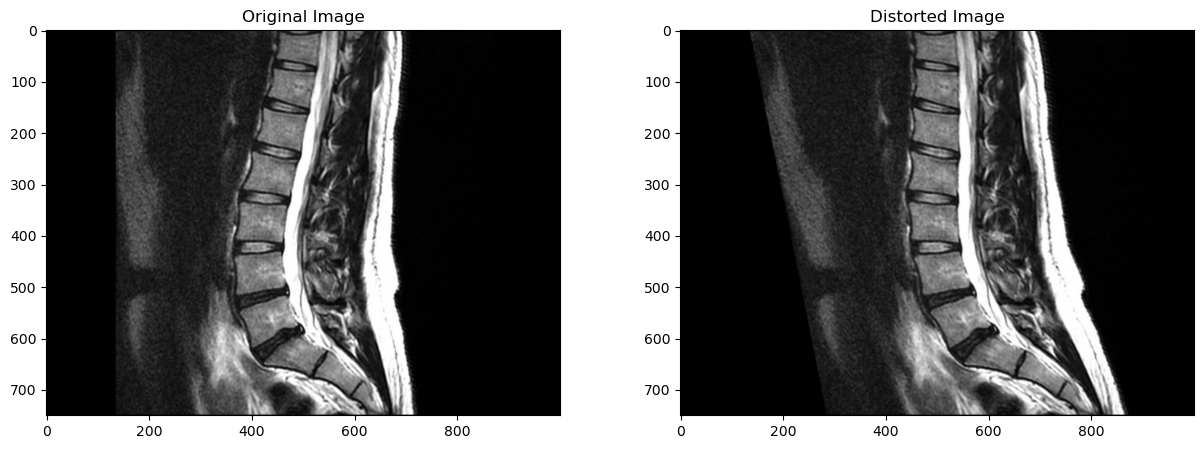

In [13]:
# Load the MRI image
img = cv2.imread('spine.jpg')

# Define a distortion matrix (e.g., a shear transformation)
distortion_matrix = np.array([[1, 0.2, 0],
                              [0, 1, 0],
                              [0, 0, 1]])

# Apply the distortion to the image
distorted_img = cv2.warpPerspective(img, distortion_matrix, (img.shape[1], img.shape[0]))

# # Define a rectification matrix (inverse of the distortion matrix)
# rectification_matrix = np.linalg.inv(distortion_matrix)

# # Rectify the image using bilinear interpolation
# rectified_img = cv2.warpPerspective(distorted_img, rectification_matrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# Display the images using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(distorted_img)
axes[1].set_title('Distorted Image')
# axes[2].imshow(rectified_img)
# axes[2].set_title('Rectified Image')
plt.show()

In [14]:
# # Display the distorted image
# plt.imshow(distorted_img)
# plt.title('Distorted Image')
# plt.show()

# # Save the distorted image
# plt.imsave('distorted_image.png', distorted_img)

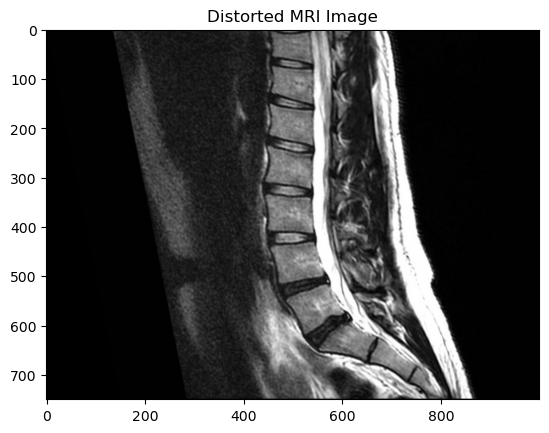

In [15]:
# Load the distorted MRI image
image = cv2.imread('spine_distorted.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the distorted MRI image using Matplotlib
plt.imshow(image_rgb)
plt.title('Distorted MRI Image')
plt.show()

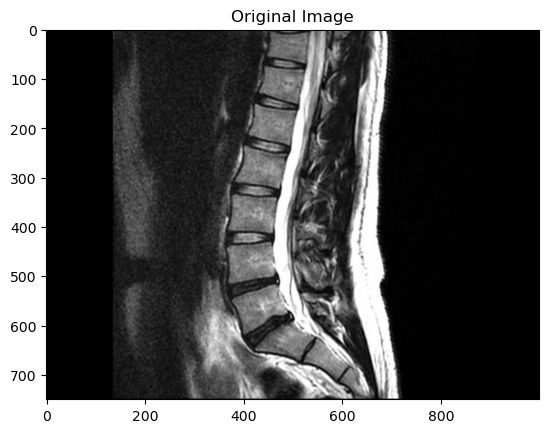

In [16]:
# Load the reference image
reference_image = cv2.imread('spine.jpg')
image_ref = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_ref)
plt.title('Original Image')
plt.show()

In [17]:
# Function to detect key_points using ORB and match between distorted and reference images
def find_gcp(distorted_image_path, reference_image_path):
    try:
        # Load the distorted and reference images in grayscale
        distorted_image = cv2.imread(distorted_image_path, 0)
        reference_image = cv2.imread(reference_image_path, 0)
        
        if distorted_image is None or reference_image is None:
            raise FileNotFoundError("Error: One or both of the image paths provided are incorrect or the files do not exist.")
        
        # Initialize ORB detector
        orb = cv2.ORB_create()

        # Detect keypoints and descriptors
        keypoints_1, descriptors_1 = orb.detectAndCompute(distorted_image, None)
        keypoints_2, descriptors_2 = orb.detectAndCompute(reference_image, None)

        if len(keypoints_1) == 0 or len(keypoints_2) == 0:
            raise ValueError("Error: ORB could not detect any keypoints in one or both of the images.")

        # Use BFMatcher (Brute Force Matcher) to find the best matches
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors_1, descriptors_2)

        if len(matches) == 0:
            raise ValueError("Error: No good matches were found between the distorted and reference images.")

        # Sort matches based on distance (lower distance is better)
        matches = sorted(matches, key=lambda x: x.distance)

        # Select the top 4 matches based on distance
        top_matches = matches[:4]

        # Draw the top 4 matches for visualization
        matched_image = cv2.drawMatches(distorted_image, keypoints_1, reference_image, keypoints_2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Convert the BGR image to RGB for plt (Matplotlib expects RGB format)
        matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

        # Display the matched image using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(matched_image_rgb)
        plt.title("Top 4 Matched Key Points")
        plt.axis('off')  # Hide axes for a cleaner look
        plt.show()

        # Extract the matching keypoints as GCPs (top 4)
        gcp_list_distorted = np.float32([keypoints_1[m.queryIdx].pt for m in top_matches])
        gcp_list_reference = np.float32([keypoints_2[m.trainIdx].pt for m in top_matches])

        return gcp_list_distorted, gcp_list_reference

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except ValueError as val_error:
        print(val_error)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

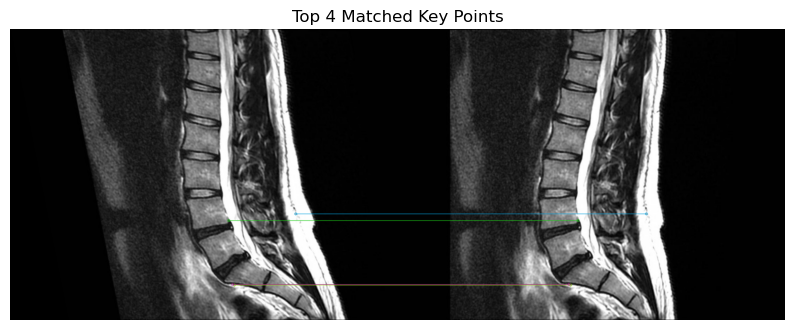

Key Points (Distorted Image): [[737.   476.  ]
 [578.88 659.52]
 [564.   493.2 ]
 [574.   658.  ]]
Key Points (Original Image): [[642.      476.     ]
 [446.40002 659.52   ]
 [465.6     493.2    ]
 [442.      658.     ]]


In [18]:
# Paths to the distorted and reference images
distorted_image_path = 'spine_distorted.png'
reference_image_path = 'spine.jpg'

# Call the function to find GCPs
gcp_distorted, gcp_reference = find_gcp(distorted_image_path, reference_image_path)

# Print the GCPs for further use
if gcp_distorted is not None and gcp_reference is not None:
    print("Key Points (Distorted Image):", gcp_distorted)
    print("Key Points (Original Image):", gcp_reference)

In [19]:
# Example points (x, y) for the distorted image and the reference model
distorted_points = np.float32([[737.0, 476.0], [578.88, 659.52], [564.0, 493.2 ], [574.0, 658.0]])
reference_points = np.float32([[642.0, 476.0], [446.40002, 659.52], [465.6, 493.2], [442.0, 658.0]])

In [20]:
matrix = cv2.getPerspectiveTransform(distorted_points, reference_points)

In [21]:
rectified_image = cv2.warpPerspective(image_rgb, matrix, (image_rgb.shape[1], image_rgb.shape[0]), flags=cv2.INTER_LINEAR)

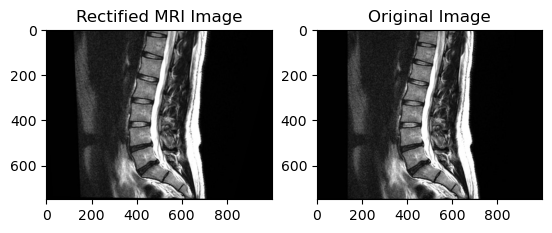

In [22]:
plt.subplot(1, 2, 1)
plt.title('Rectified MRI Image')
plt.imshow(cv2.cvtColor(rectified_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Original Image')
reference_image = cv2.imread('spine.jpg')
plt.imshow(cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB))

plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

# Load the reference anatomical model image
reference_image = cv2.imread('spine.jpg')

# Resize reference image to match the rectified image size if needed
reference_image = cv2.resize(reference_image, (rectified_image.shape[1], rectified_image.shape[0]))

# Compute MSE between rectified MRI image and reference anatomical model
mse_value = mean_squared_error(rectified_image.flatten(), reference_image.flatten())
print(f'Mean Squared Error (MSE): {mse_value}')

Mean Squared Error (MSE): 41.083472


## Report

# Lab Task 3: Drone Image Rectification

Text(0.5, 1.0, 'Distorted Image')

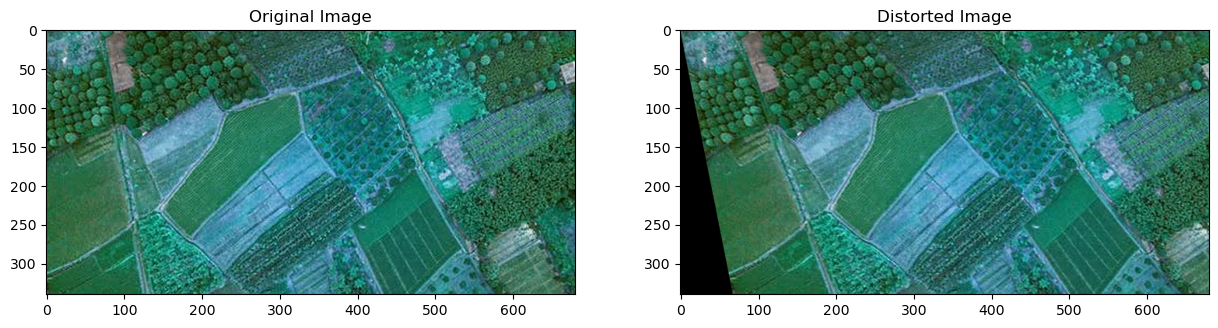

In [24]:
# Load the agricultural image captured by drone
img = cv2.imread('Field.jpg')
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define a distortion matrix (e.g., a shear transformation)
distortion_matrix = np.array([[1, 0.2, 0],
                              [0, 1, 0],
                              [0, 0, 1]])

# Apply the distortion to the image
distorted_img = cv2.warpPerspective(img, distortion_matrix, (img.shape[1], img.shape[0]))

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(distorted_img)
axes[1].set_title('Distorted Image')

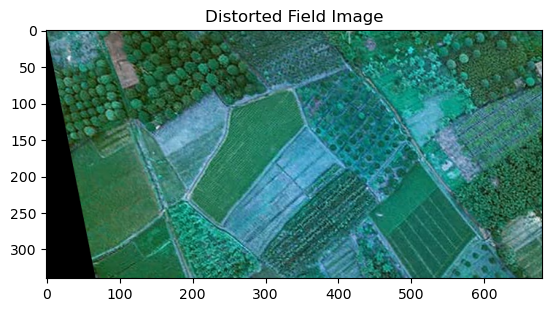

In [25]:
# Load the distorted field image
image = cv2.imread('Field_distorted.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the distorted MRI image using Matplotlib
plt.imshow(image_rgb)
plt.title('Distorted Field Image')
plt.show()

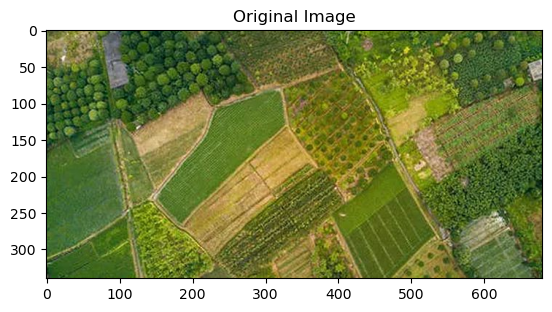

In [26]:
# Load the reference image
reference_image = cv2.imread('Field.jpg')
image_ref = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_ref)
plt.title('Original Image')
plt.show()

In [27]:
def find_gcp(distorted_image_path, reference_image_path):
    try:
        # Load the distorted and reference images in grayscale
        distorted_image = cv2.imread(distorted_image_path, 0)
        reference_image = cv2.imread(reference_image_path, 0)
        
        if distorted_image is None or reference_image is None:
            raise FileNotFoundError("Error: One or both of the image paths provided are incorrect or the files do not exist.")
        
        # Initialize ORB detector
        orb = cv2.ORB_create()

        # Detect keypoints and descriptors
        keypoints_1, descriptors_1 = orb.detectAndCompute(distorted_image, None)
        keypoints_2, descriptors_2 = orb.detectAndCompute(reference_image, None)

        if len(keypoints_1) == 0 or len(keypoints_2) == 0:
            raise ValueError("Error: ORB could not detect any keypoints in one or both of the images.")

        # Use BFMatcher (Brute Force Matcher) to find the best matches
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors_1, descriptors_2)

        if len(matches) == 0:
            raise ValueError("Error: No good matches were found between the distorted and reference images.")

        # Sort matches based on distance (lower distance is better)
        matches = sorted(matches, key=lambda x: x.distance)

        # Select the top 4 matches based on distance
        top_matches = matches[:4]

        # Draw the top 4 matches for visualization
        matched_image = cv2.drawMatches(distorted_image, keypoints_1, reference_image, keypoints_2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Convert the BGR image to RGB for plt (Matplotlib expects RGB format)
        matched_image_rgb = cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)

        # Display the matched image using matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(matched_image_rgb)
        plt.title("Top 4 Matched Key Points")
        plt.axis('off')  # Hide axes for a cleaner look
        plt.show()

        # Extract the matching keypoints as GCPs (top 4)
        gcp_list_distorted = np.float32([keypoints_1[m.queryIdx].pt for m in top_matches])
        gcp_list_reference = np.float32([keypoints_2[m.trainIdx].pt for m in top_matches])

        return gcp_list_distorted, gcp_list_reference

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except ValueError as val_error:
        print(val_error)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

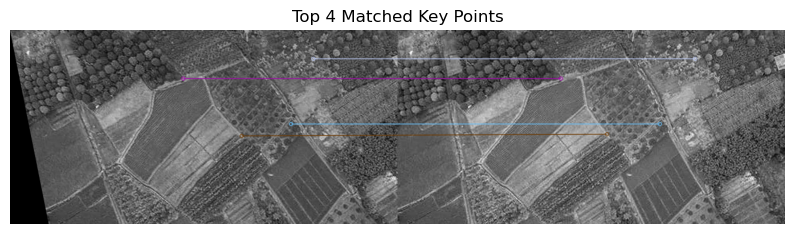

Key Points (Distorted Image): [[303.5751   84.6029 ]
 [532.       50.     ]
 [492.6875  164.22916]
 [406.09393 185.13106]]
Key Points (Original Image): [[286.15686  84.6029 ]
 [522.       50.     ]
 [459.84167 164.22916]
 [367.27612 182.14508]]


In [28]:
# Paths to the distorted and reference images
distorted_image_path = 'Field_distorted.png'
reference_image_path = 'Field.jpg'

# Call the function to find GCPs
gcp_distorted, gcp_reference = find_gcp(distorted_image_path, reference_image_path)

# Print the GCPs for further use
if gcp_distorted is not None and gcp_reference is not None:
    print("Key Points (Distorted Image):", gcp_distorted)
    print("Key Points (Original Image):", gcp_reference)

In [29]:
src_points = np.array([[303.5751, 84.6029], [532.0, 50.0], [492.6875, 164.22916], [406.09393, 185.13106]], dtype='float32')
dst_points = np.array([[286.15686, 84.6029], [522.0, 50.0], [459.84167, 164.22916], [367.27612, 182.14508]], dtype='float32')
transformation_matrix = cv2.getPerspectiveTransform(src_points, dst_points)

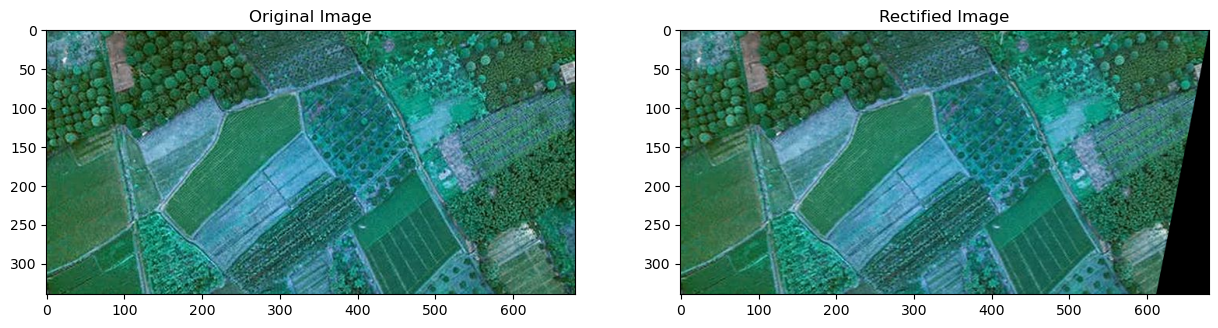

In [31]:
rectified_image = cv2.warpPerspective(image, transformation_matrix, (1000, 1000), flags=cv2.INTER_LINEAR)

rectification_matrix = np.linalg.inv(distortion_matrix)

# Rectify the image using bilinear interpolation
rectified_image = cv2.warpPerspective(distorted_img, rectification_matrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# Display the images using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(rectified_image)
axes[1].set_title('Rectified Image')
plt.show()

## Report

# Lab Task 4: Historical Photo Restoration

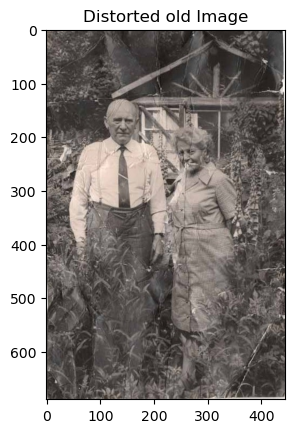

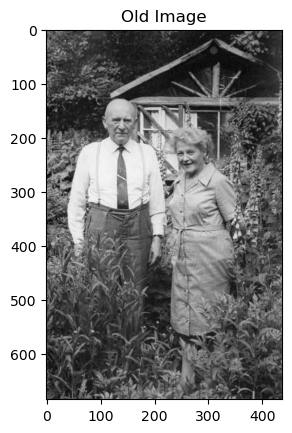

In [32]:
# Load the distorted field image
image = cv2.imread('photo_distort.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the distorted MRI image using Matplotlib
plt.imshow(image_rgb)
plt.title('Distorted old Image')
plt.show()

# Load the distorted field image
image_ref = cv2.imread('photo.jpg')
image_ref_rgb = cv2.cvtColor(image_ref, cv2.COLOR_BGR2RGB)

# Display the distorted MRI image using Matplotlib
plt.imshow(image_ref_rgb)
plt.title('Old Image')
plt.show()

In [33]:
# Define key points on the distorted image and their corresponding points on the reference image
distorted_points = np.float32([[100, 150], [400, 150], [100, 400], [400, 400]])
reference_points = np.float32([[120, 170], [420, 160], [110, 420], [430, 410]])

# Calculate the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(distorted_points, reference_points)

# Apply the perspective transformation
height, width = image_ref.shape[:2]
rectified_image = cv2.warpPerspective(image, matrix, (width, height))

# Convert rectified image from BGR to RGB
rectified_image_rgb = cv2.cvtColor(rectified_image, cv2.COLOR_BGR2RGB)

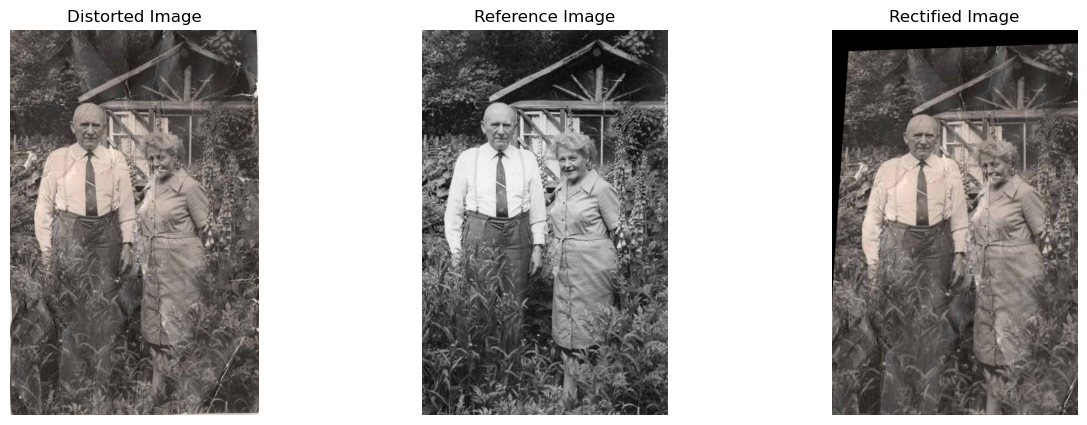

In [34]:
# Plot the images using matplotlib
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display distorted image
ax[0].imshow(image_rgb)
ax[0].set_title('Distorted Image')
ax[0].axis('off')

# Display reference image
ax[1].imshow(image_ref_rgb)
ax[1].set_title('Reference Image')
ax[1].axis('off')

# Display rectified image
ax[2].imshow(rectified_image_rgb)
ax[2].set_title('Rectified Image')
ax[2].axis('off')

plt.show()

## Report

# Lab Task 5: Architectural Image Rectification

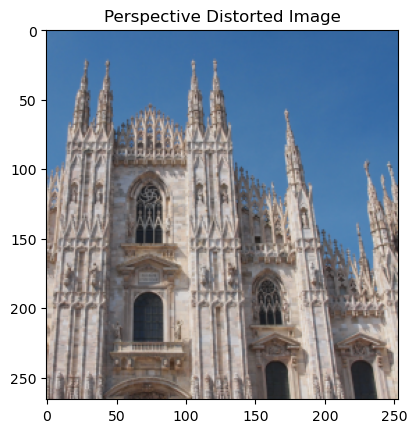

In [35]:
# Load the distorted image
distorted_image = cv2.imread('Architecture_distort.png')
distorted_image_rgb = cv2.cvtColor(distorted_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Display the distorted MRI image using Matplotlib
plt.imshow(distorted_image_rgb)
plt.title('Perspective Distorted Image')
plt.show()

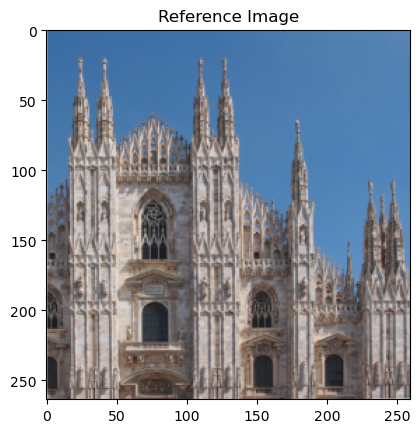

In [36]:
# Load the distorted image
reference_image = cv2.imread('Architecture.png')
reference_image_rgb = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Display the distorted MRI image using Matplotlib
plt.imshow(reference_image_rgb)
plt.title('Reference Image')
plt.show()

In [37]:
# Get image dimensions
height, width = distorted_image_rgb.shape[:2]

# Define the corner points
top_left = (0, 0)
top_right = (width - 1, 0)
bottom_right = (width - 1, height - 1)
bottom_left = (0, height - 1)

print("Dis - Top-left corner:", top_left)
print("Dis - Top-right corner:", top_right)
print("Dis - Bottom-right corner:", bottom_right)
print("Dis - Bottom-left corner:", bottom_left)

Dis - Top-left corner: (0, 0)
Dis - Top-right corner: (252, 0)
Dis - Bottom-right corner: (252, 265)
Dis - Bottom-left corner: (0, 265)


In [38]:
# Get image dimensions
height, width = reference_image_rgb.shape[:2]

# Define the corner points
top_left = (0, 0)
top_right = (width - 1, 0)
bottom_right = (width - 1, height - 1)
bottom_left = (0, height - 1)

print("Top-left corner:", top_left)
print("Top-right corner:", top_right)
print("Bottom-right corner:", bottom_right)
print("Bottom-left corner:", bottom_left)

Top-left corner: (0, 0)
Top-right corner: (259, 0)
Bottom-right corner: (259, 263)
Bottom-left corner: (0, 263)


In [39]:
distorted_points = np.array([
    [0, 0],   # Point 1
    [252, 0],   # Point 2
    [252, 265],   # Point 3
    [0, 265]    # Point 4
], dtype='float32')

rectified_points = np.array([
    [0, 0],       # Top-left corner
    [259, 0],     # Top-right corner
    [259, 263],   # Bottom-right corner
    [0, 263]      # Bottom-left corner
], dtype='float32')

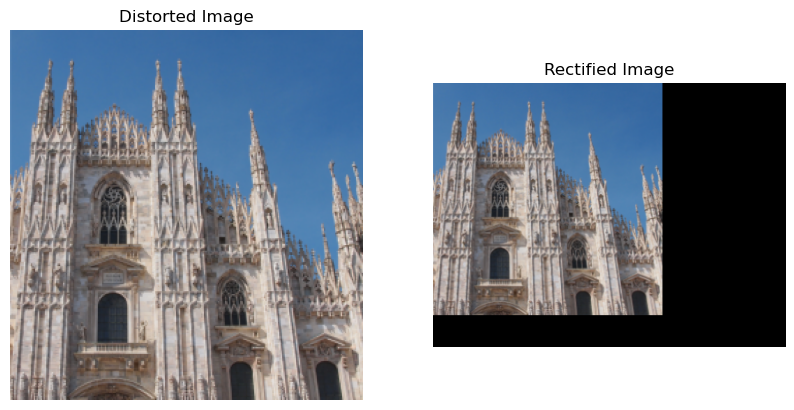

In [40]:
# Compute the homography matrix
matrix, _ = cv2.findHomography(distorted_points, rectified_points)

# Get the dimensions of the rectified image
rectified_width = 400
rectified_height = 300

# Warp the image using the homography matrix
rectified_image = cv2.warpPerspective(distorted_image_rgb, matrix, (rectified_width, rectified_height), flags=cv2.INTER_LINEAR)

# Plot the images using matplotlib
plt.figure(figsize=(10, 5))

# Display the distorted image
plt.subplot(1, 2, 1)
plt.imshow(distorted_image_rgb)
plt.title('Distorted Image')
plt.axis('off')

# Display the rectified image
plt.subplot(1, 2, 2)
plt.imshow(rectified_image)
plt.title('Rectified Image')
plt.axis('off')

plt.show()

## Report

# Thank You